In [1]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df = pd.read_csv('payment.csv')
df

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status
0,200576926,20200203,20200213,14-02-2020 00:00,2020,44894.85,NA10,1.930455e+09,0
1,200592182,20190726,20190808,01-08-2019 00:00,2019,928.66,NAM4,1.929664e+09,0
2,200230690,20190306,20190324,18-03-2019 00:00,2019,1818.92,NAM4,1.928915e+09,0
3,200778355,20190912,20191002,02-10-2019 00:00,2019,18087.02,NAD1,1.929868e+09,0
4,200769623,20190913,20190928,24-09-2019 00:00,2019,3795.70,NAH4,1.929868e+09,0
...,...,...,...,...,...,...,...,...,...
49995,200407025,20200414,20200429,NaN,2020,122734.80,NAA8,1.930778e+09,1
49996,200769623,20200410,20200425,NaN,2020,50045.40,NAH4,1.930772e+09,1
49997,200769623,20200317,20200401,NaN,2020,16067.93,NAH4,1.930660e+09,1
49998,200769623,20200427,20200512,NaN,2020,36834.06,NAH4,1.930828e+09,1


# preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cust_number          50000 non-null  object 
 1   invoice_create_date  50000 non-null  int64  
 2   due_in_date          50000 non-null  int64  
 3   clear_date           46553 non-null  object 
 4   year                 50000 non-null  int64  
 5   total_open_amount    50000 non-null  float64
 6   cust_payment_terms   50000 non-null  object 
 7   invoice_id           49994 non-null  float64
 8   status               50000 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 3.4+ MB


In [4]:
df.isnull().sum()

cust_number               0
invoice_create_date       0
due_in_date               0
clear_date             3447
year                      0
total_open_amount         0
cust_payment_terms        0
invoice_id                6
status                    0
dtype: int64

# Date-Time Conversion

In [5]:
from datetime import datetime

In [6]:
df['clear_date']=pd.to_datetime(df['clear_date'],infer_datetime_format=True)
df['clear_date'].head()

0   2020-02-14
1   2019-08-01
2   2019-03-18
3   2019-10-02
4   2019-09-24
Name: clear_date, dtype: datetime64[ns]

In [7]:
df['due_in_date']=pd.to_datetime(df['due_in_date'],format='%Y%m%d')
df['due_in_date'].head()

0   2020-02-13
1   2019-08-08
2   2019-03-24
3   2019-10-02
4   2019-09-28
Name: due_in_date, dtype: datetime64[ns]

In [8]:
df['invoice_create_date']=pd.to_datetime(df['invoice_create_date'],format='%Y%m%d')
df['invoice_create_date'].head()

0   2020-02-03
1   2019-07-26
2   2019-03-06
3   2019-09-12
4   2019-09-13
Name: invoice_create_date, dtype: datetime64[ns]

In [9]:
df.head()

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status
0,200576926,2020-02-03,2020-02-13,2020-02-14,2020,44894.85,NA10,1.930455e+09,0
1,200592182,2019-07-26,2019-08-08,2019-08-01,2019,928.66,NAM4,1.929664e+09,0
2,200230690,2019-03-06,2019-03-24,2019-03-18,2019,1818.92,NAM4,1.928915e+09,0
3,200778355,2019-09-12,2019-10-02,2019-10-02,2019,18087.02,NAD1,1.929868e+09,0
4,200769623,2019-09-13,2019-09-28,2019-09-24,2019,3795.70,NAH4,1.929868e+09,0


In [10]:
df.dropna(axis=1,how='all',inplace=True)
df.shape

(50000, 9)

In [11]:
df.dropna(axis=0,subset=['invoice_id'],inplace=True)
df.reset_index(drop=True,inplace=True)
df.shape
df

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status
0,200576926,2020-02-03,2020-02-13,2020-02-14,2020,44894.85,NA10,1.930455e+09,0
1,200592182,2019-07-26,2019-08-08,2019-08-01,2019,928.66,NAM4,1.929664e+09,0
2,200230690,2019-03-06,2019-03-24,2019-03-18,2019,1818.92,NAM4,1.928915e+09,0
3,200778355,2019-09-12,2019-10-02,2019-10-02,2019,18087.02,NAD1,1.929868e+09,0
4,200769623,2019-09-13,2019-09-28,2019-09-24,2019,3795.70,NAH4,1.929868e+09,0
...,...,...,...,...,...,...,...,...,...
49989,200407025,2020-04-14,2020-04-29,NaT,2020,122734.80,NAA8,1.930778e+09,1
49990,200769623,2020-04-10,2020-04-25,NaT,2020,50045.40,NAH4,1.930772e+09,1
49991,200769623,2020-03-17,2020-04-01,NaT,2020,16067.93,NAH4,1.930660e+09,1
49992,200769623,2020-04-27,2020-05-12,NaT,2020,36834.06,NAH4,1.930828e+09,1


In [12]:
 for cols in df.columns:   
    print(f"{cols} - {df[f'{cols}'].nunique()}")

cust_number - 1089
invoice_create_date - 500
due_in_date - 540
clear_date - 404
year - 2
total_open_amount - 45297
cust_payment_terms - 74
invoice_id - 49994
status - 2


In [13]:
unique_cols =  [x for x in df.columns if df[x].nunique()==1] 
print(unique_cols)
df.drop(unique_cols,axis=1,inplace=True)
df.columns

[]


Index(['cust_number', 'invoice_create_date', 'due_in_date', 'clear_date',
       'year', 'total_open_amount', 'cust_payment_terms', 'invoice_id',
       'status'],
      dtype='object')

In [14]:
df.isnull().any()

cust_number            False
invoice_create_date    False
due_in_date            False
clear_date              True
year                   False
total_open_amount      False
cust_payment_terms     False
invoice_id             False
status                 False
dtype: bool

In [15]:
df['delay']=(df['clear_date']-df['due_in_date']).dt.days

In [16]:
df.sort_values(by='invoice_create_date',inplace=True) # sorting in ascending order by document_create_date.1
df

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
507,CCCA02,2018-12-30,2019-02-03,2019-03-01,2019,13039.64,NAG2,1.928537e+09,0,26.0
22268,200769623,2018-12-30,2019-01-14,2019-01-10,2019,33983.19,NAH4,1.928542e+09,0,-4.0
40600,200769623,2018-12-30,2019-01-14,2019-01-16,2019,41807.51,NAH4,1.928541e+09,0,2.0
24419,200255310,2018-12-30,2019-01-14,2019-01-14,2019,1929.96,NAU5,1.928543e+09,0,0.0
1221,200769623,2018-12-30,2019-01-14,2019-01-10,2019,26130.42,NAH4,1.928543e+09,0,-4.0
...,...,...,...,...,...,...,...,...,...,...
47964,200769623,2020-05-12,2020-05-27,NaT,2020,1247.36,NAH4,1.930887e+09,1,NaN
49230,200762950,2020-05-13,2020-05-28,NaT,2020,106094.04,NAA8,1.930885e+09,1,NaN
47719,200915438,2020-05-14,2020-05-29,NaT,2020,17812.00,NAA8,1.930876e+09,1,NaN
47481,200915438,2020-05-14,2020-05-29,NaT,2020,7800.00,NAA8,1.930880e+09,1,NaN


In [17]:
df.head()

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
507,CCCA02,2018-12-30,2019-02-03,2019-03-01,2019,13039.64,NAG2,1.928537e+09,0,26.0
22268,200769623,2018-12-30,2019-01-14,2019-01-10,2019,33983.19,NAH4,1.928542e+09,0,-4.0
40600,200769623,2018-12-30,2019-01-14,2019-01-16,2019,41807.51,NAH4,1.928541e+09,0,2.0
24419,200255310,2018-12-30,2019-01-14,2019-01-14,2019,1929.96,NAU5,1.928543e+09,0,0.0
1221,200769623,2018-12-30,2019-01-14,2019-01-10,2019,26130.42,NAH4,1.928543e+09,0,-4.0


In [18]:
test_data = df[df.clear_date.isnull()].reset_index()
test_data.drop(columns=['index'],inplace=True)
test_data

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
0,200780383,2020-02-27,2020-03-13,NaT,2020,50394.62,NAA8,1.930577e+09,1,NaN
1,140106181,2020-02-27,2020-03-08,NaT,2020,10240.80,CA10,2.960618e+09,1,NaN
2,CCU013,2020-02-27,2020-02-27,NaT,2020,9955.20,NAX2,1.930577e+09,1,NaN
3,200742521,2020-02-27,2020-03-13,NaT,2020,23155.48,NAA8,1.930567e+09,1,NaN
4,200472086,2020-02-27,2020-03-13,NaT,2020,95862.39,NAA8,1.930575e+09,1,NaN
...,...,...,...,...,...,...,...,...,...,...
3442,200769623,2020-05-12,2020-05-27,NaT,2020,1247.36,NAH4,1.930887e+09,1,NaN
3443,200762950,2020-05-13,2020-05-28,NaT,2020,106094.04,NAA8,1.930885e+09,1,NaN
3444,200915438,2020-05-14,2020-05-29,NaT,2020,17812.00,NAA8,1.930876e+09,1,NaN
3445,200915438,2020-05-14,2020-05-29,NaT,2020,7800.00,NAA8,1.930880e+09,1,NaN


In [19]:
ts = test_data.copy()

In [20]:
y_test = test_data["delay"]
y_test

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3442   NaN
3443   NaN
3444   NaN
3445   NaN
3446   NaN
Name: delay, Length: 3447, dtype: float64

In [21]:
x_test = test_data.iloc[:,:-1].copy()
x_test

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status
0,200780383,2020-02-27,2020-03-13,NaT,2020,50394.62,NAA8,1.930577e+09,1
1,140106181,2020-02-27,2020-03-08,NaT,2020,10240.80,CA10,2.960618e+09,1
2,CCU013,2020-02-27,2020-02-27,NaT,2020,9955.20,NAX2,1.930577e+09,1
3,200742521,2020-02-27,2020-03-13,NaT,2020,23155.48,NAA8,1.930567e+09,1
4,200472086,2020-02-27,2020-03-13,NaT,2020,95862.39,NAA8,1.930575e+09,1
...,...,...,...,...,...,...,...,...,...
3442,200769623,2020-05-12,2020-05-27,NaT,2020,1247.36,NAH4,1.930887e+09,1
3443,200762950,2020-05-13,2020-05-28,NaT,2020,106094.04,NAA8,1.930885e+09,1
3444,200915438,2020-05-14,2020-05-29,NaT,2020,17812.00,NAA8,1.930876e+09,1
3445,200915438,2020-05-14,2020-05-29,NaT,2020,7800.00,NAA8,1.930880e+09,1


In [22]:
train_data2 = df[df.clear_date.notnull()].reset_index() #train set on non-null clear date
train_data2.drop(columns=['index'],inplace=True)
train_data2

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
0,CCCA02,2018-12-30,2019-02-03,2019-03-01,2019,13039.64,NAG2,1.928537e+09,0,26.0
1,200769623,2018-12-30,2019-01-14,2019-01-10,2019,33983.19,NAH4,1.928542e+09,0,-4.0
2,200769623,2018-12-30,2019-01-14,2019-01-16,2019,41807.51,NAH4,1.928541e+09,0,2.0
3,200255310,2018-12-30,2019-01-14,2019-01-14,2019,1929.96,NAU5,1.928543e+09,0,0.0
4,200769623,2018-12-30,2019-01-14,2019-01-10,2019,26130.42,NAH4,1.928543e+09,0,-4.0
...,...,...,...,...,...,...,...,...,...,...
46542,200763152,2020-02-27,2020-03-13,2020-03-16,2020,33765.66,NAA8,1.930571e+09,0,3.0
46543,200744707,2020-02-27,2020-03-13,2020-03-16,2020,39408.22,NAA8,1.930574e+09,0,3.0
46544,200794332,2020-02-27,2020-03-13,2020-03-12,2020,12610.49,NAAX,1.930577e+09,0,-1.0
46545,200700919,2020-02-27,2020-03-18,2020-03-20,2020,90195.02,NAD1,1.930580e+09,0,2.0


In [23]:
# Making use of offset to find date 1.5 months prior to 2020-02-27
x = train_data2['invoice_create_date'].iloc[-1] - pd.DateOffset(months=1, days=15)
y = train_data2['invoice_create_date'].loc[train_data2['invoice_create_date'] <= x].iloc[-1]
print(y) 
train_data2['invoice_create_date'].loc[train_data2['invoice_create_date'] == y].last_valid_index()

2020-01-12 00:00:00


41778

In [24]:
# dataframe for val2
val2 = train_data2.iloc[41779: , :].copy()
val2.reset_index(drop=True,inplace=True)
val2.shape

(4768, 10)

In [25]:
train_data1 = pd.concat([train_data2, val2]).drop_duplicates(keep=False)
train_data1

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
0,CCCA02,2018-12-30,2019-02-03,2019-03-01,2019,13039.64,NAG2,1.928537e+09,0,26.0
1,200769623,2018-12-30,2019-01-14,2019-01-10,2019,33983.19,NAH4,1.928542e+09,0,-4.0
2,200769623,2018-12-30,2019-01-14,2019-01-16,2019,41807.51,NAH4,1.928541e+09,0,2.0
3,200255310,2018-12-30,2019-01-14,2019-01-14,2019,1929.96,NAU5,1.928543e+09,0,0.0
4,200769623,2018-12-30,2019-01-14,2019-01-10,2019,26130.42,NAH4,1.928543e+09,0,-4.0
...,...,...,...,...,...,...,...,...,...,...
41774,200769623,2020-01-12,2020-01-27,2020-01-28,2020,69844.79,NAH4,1.930385e+09,0,1.0
41775,200769623,2020-01-12,2020-01-27,2020-01-23,2020,1185.74,NAH4,1.930388e+09,0,-4.0
41776,200752302,2020-01-12,2020-01-27,2020-01-27,2020,84296.28,NAA8,1.930381e+09,0,0.0
41777,200744019,2020-01-12,2020-01-27,2020-01-28,2020,19616.47,NAA8,1.930389e+09,0,1.0


In [26]:
x2 = train_data1['invoice_create_date'].iloc[-1] - pd.DateOffset(months=1, days=15)
y2 = train_data1['invoice_create_date'].loc[train_data1['invoice_create_date'] <= x2].iloc[-1]
print(y2)
train_data1['invoice_create_date'].loc[train_data1['invoice_create_date'] == y2].last_valid_index()

2019-11-27 00:00:00


38486

In [27]:
val1 = train_data1.iloc[38486: , :].copy()
val1.reset_index(drop=True,inplace=True)
val1

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
0,200780383,2019-11-27,2019-12-12,2019-12-12,2019,39193.09,NAA8,1.930198e+09,0,0.0
1,200780383,2019-11-28,2019-12-13,2019-12-13,2019,134145.60,NAA8,1.930202e+09,0,0.0
2,200739044,2019-11-28,2019-12-13,2019-12-18,2019,29035.26,NAA8,1.930201e+09,0,5.0
3,140104409,2019-11-28,2019-12-13,2019-12-09,2019,5547.11,CA10,2.960592e+09,0,-4.0
4,200920735,2019-11-28,2019-12-13,2019-12-13,2019,95681.58,NAA8,1.930199e+09,0,0.0
...,...,...,...,...,...,...,...,...,...,...
3288,200769623,2020-01-12,2020-01-27,2020-01-28,2020,69844.79,NAH4,1.930385e+09,0,1.0
3289,200769623,2020-01-12,2020-01-27,2020-01-23,2020,1185.74,NAH4,1.930388e+09,0,-4.0
3290,200752302,2020-01-12,2020-01-27,2020-01-27,2020,84296.28,NAA8,1.930381e+09,0,0.0
3291,200744019,2020-01-12,2020-01-27,2020-01-28,2020,19616.47,NAA8,1.930389e+09,0,1.0


In [28]:
train_data = pd.concat([train_data1, val1]).drop_duplicates(keep=False)
train_data

,cust_number,invoice_create_date,due_in_date,clear_date,year,total_open_amount,cust_payment_terms,invoice_id,status,delay
0,CCCA02,2018-12-30,2019-02-03,2019-03-01,2019,13039.64,NAG2,1.928537e+09,0,26.0
1,200769623,2018-12-30,2019-01-14,2019-01-10,2019,33983.19,NAH4,1.928542e+09,0,-4.0
2,200769623,2018-12-30,2019-01-14,2019-01-16,2019,41807.51,NAH4,1.928541e+09,0,2.0
3,200255310,2018-12-30,2019-01-14,2019-01-14,2019,1929.96,NAU5,1.928543e+09,0,0.0
4,200769623,2018-12-30,2019-01-14,2019-01-10,2019,26130.42,NAH4,1.928543e+09,0,-4.0
...,...,...,...,...,...,...,...,...,...,...
38481,200769623,2019-11-27,2019-12-12,2019-12-09,2019,8877.58,NAH4,1.930195e+09,0,-3.0
38482,200726979,2019-11-27,2019-12-12,2019-12-12,2019,27.60,NAA8,1.930196e+09,0,0.0
38483,200769623,2019-11-27,2019-12-12,2019-12-09,2019,17356.11,NAH4,1.930195e+09,0,-3.0
38484,140106408,2019-11-27,2019-12-07,2019-12-19,2019,1478.78,CA10,2.960592e+09,0,12.0


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38486 entries, 0 to 38485
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cust_number          38486 non-null  object        
 1   invoice_create_date  38486 non-null  datetime64[ns]
 2   due_in_date          38486 non-null  datetime64[ns]
 3   clear_date           38486 non-null  datetime64[ns]
 4   year                 38486 non-null  int64         
 5   total_open_amount    38486 non-null  float64       
 6   cust_payment_terms   38486 non-null  object        
 7   invoice_id           38486 non-null  float64       
 8   status               38486 non-null  int64         
 9   delay                38486 non-null  float64       
dtypes: datetime64[ns](3), float64(3), int64(2), object(2)
memory usage: 3.2+ MB


# EDA on train set

In [30]:
train_data.cust_number.value_counts()

200769623    9081
200726979    1456
200762301    1238
200759878    1050
200794332     904
             ... 
200471970       1
100044019       1
200856934       1
200735741       1
200789896       1
Name: cust_number, Length: 1018, dtype: int64

In [31]:
len(dict(train_data.cust_number.value_counts()))

1018

In [32]:
train_data.clear_date.min()

Timestamp('2019-01-07 00:00:00')

In [33]:
train_data.clear_date.max()

Timestamp('2019-12-31 00:00:00')

In [34]:
clear_month = train_data.clear_date.dt.month
clear_month.value_counts()

5     4060
4     3783
8     3620
11    3614
10    3552
7     3501
3     3495
9     3413
6     3303
2     2871
12    1693
1     1581
Name: clear_date, dtype: int64

<AxesSubplot:xlabel='clear_date', ylabel='count'>

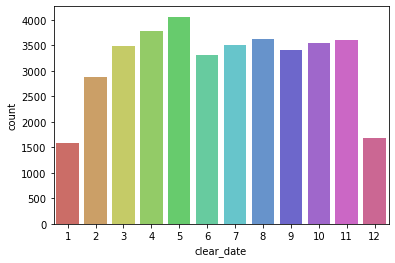

In [35]:
sns.countplot(x=clear_month, palette="hls")

In [36]:
train_data['total_open_amount'].describe().apply(lambda x: format(x,'f'))

count      38486.000000
mean       32314.096706
std        40729.040800
min            0.860000
25%         4687.110000
50%        17226.870000
75%        46702.975000
max      1506680.640000
Name: total_open_amount, dtype: object

In [37]:
open_amount_bins = pd.qcut(train_data['total_open_amount'],q=10)
open_amount_bins.value_counts()

(0.859, 825.845]           3849
(825.845, 2924.8]          3849
(6942.5, 12634.45]         3849
(17226.87, 25021.23]       3849
(38993.15, 55517.87]       3849
(82630.905, 1506680.64]    3849
(2924.8, 6942.5]           3848
(12634.45, 17226.87]       3848
(25021.23, 38993.15]       3848
(55517.87, 82630.905]      3848
Name: total_open_amount, dtype: int64

In [38]:
amount_bins = [0,5000,10000,50000,100000,1100000]
new_open_amount_bin = pd.cut(train_data['total_open_amount'], bins = amount_bins)

<AxesSubplot:xlabel='total_open_amount', ylabel='count'>

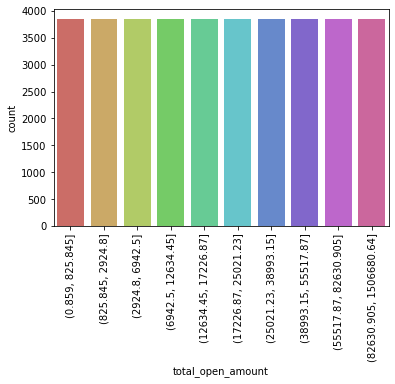

In [39]:
plt.xticks(fontsize=10, rotation=90)
sns.countplot(x=open_amount_bins, palette="hls")

In [40]:
train_data.delay[train_data.delay<0].count()

13778

In [41]:
train_data['delay']=train_data.delay.apply(lambda x: 0 if x<0 else x)
train_data.delay[train_data.delay<0].count()

0

In [42]:
train_data.delay.describe()

count    38486.000000
mean         2.875045
std          9.728552
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        305.000000
Name: delay, dtype: float64

# Relation between total_open_amount and delay

In [43]:
delay_bins = [0,15,30,45,60,300]
delay_bucket = pd.cut(train_data['delay'], bins = delay_bins)
pd.crosstab(index = new_open_amount_bin, columns =delay_bucket)

delay,"(0, 15]","(15, 30]","(30, 45]","(45, 60]","(60, 300]"
total_open_amount,,,,,
"(0, 5000]",3371,88,116,83,107
"(5000, 10000]",1528,84,55,38,19
"(10000, 50000]",6365,344,203,112,70
"(50000, 100000]",2567,79,20,14,22
"(100000, 1100000]",1174,17,9,9,6


<AxesSubplot:xlabel='total_open_amount', ylabel='count'>

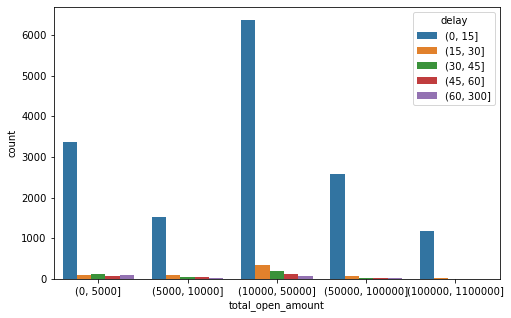

In [44]:
plt.figure(figsize=(8,5))
plt.xlabel("Amount bin")
sns.countplot(x = new_open_amount_bin, hue=delay_bucket)

In [45]:
train_data.corr()

,year,total_open_amount,invoice_id,status,delay
year,NaN,NaN,NaN,NaN,NaN
total_open_amount,NaN,1.000000,0.180738,NaN,-0.039994
invoice_id,NaN,0.180738,1.000000,NaN,0.098840
status,NaN,NaN,NaN,NaN,NaN
delay,NaN,-0.039994,0.098840,NaN,1.000000


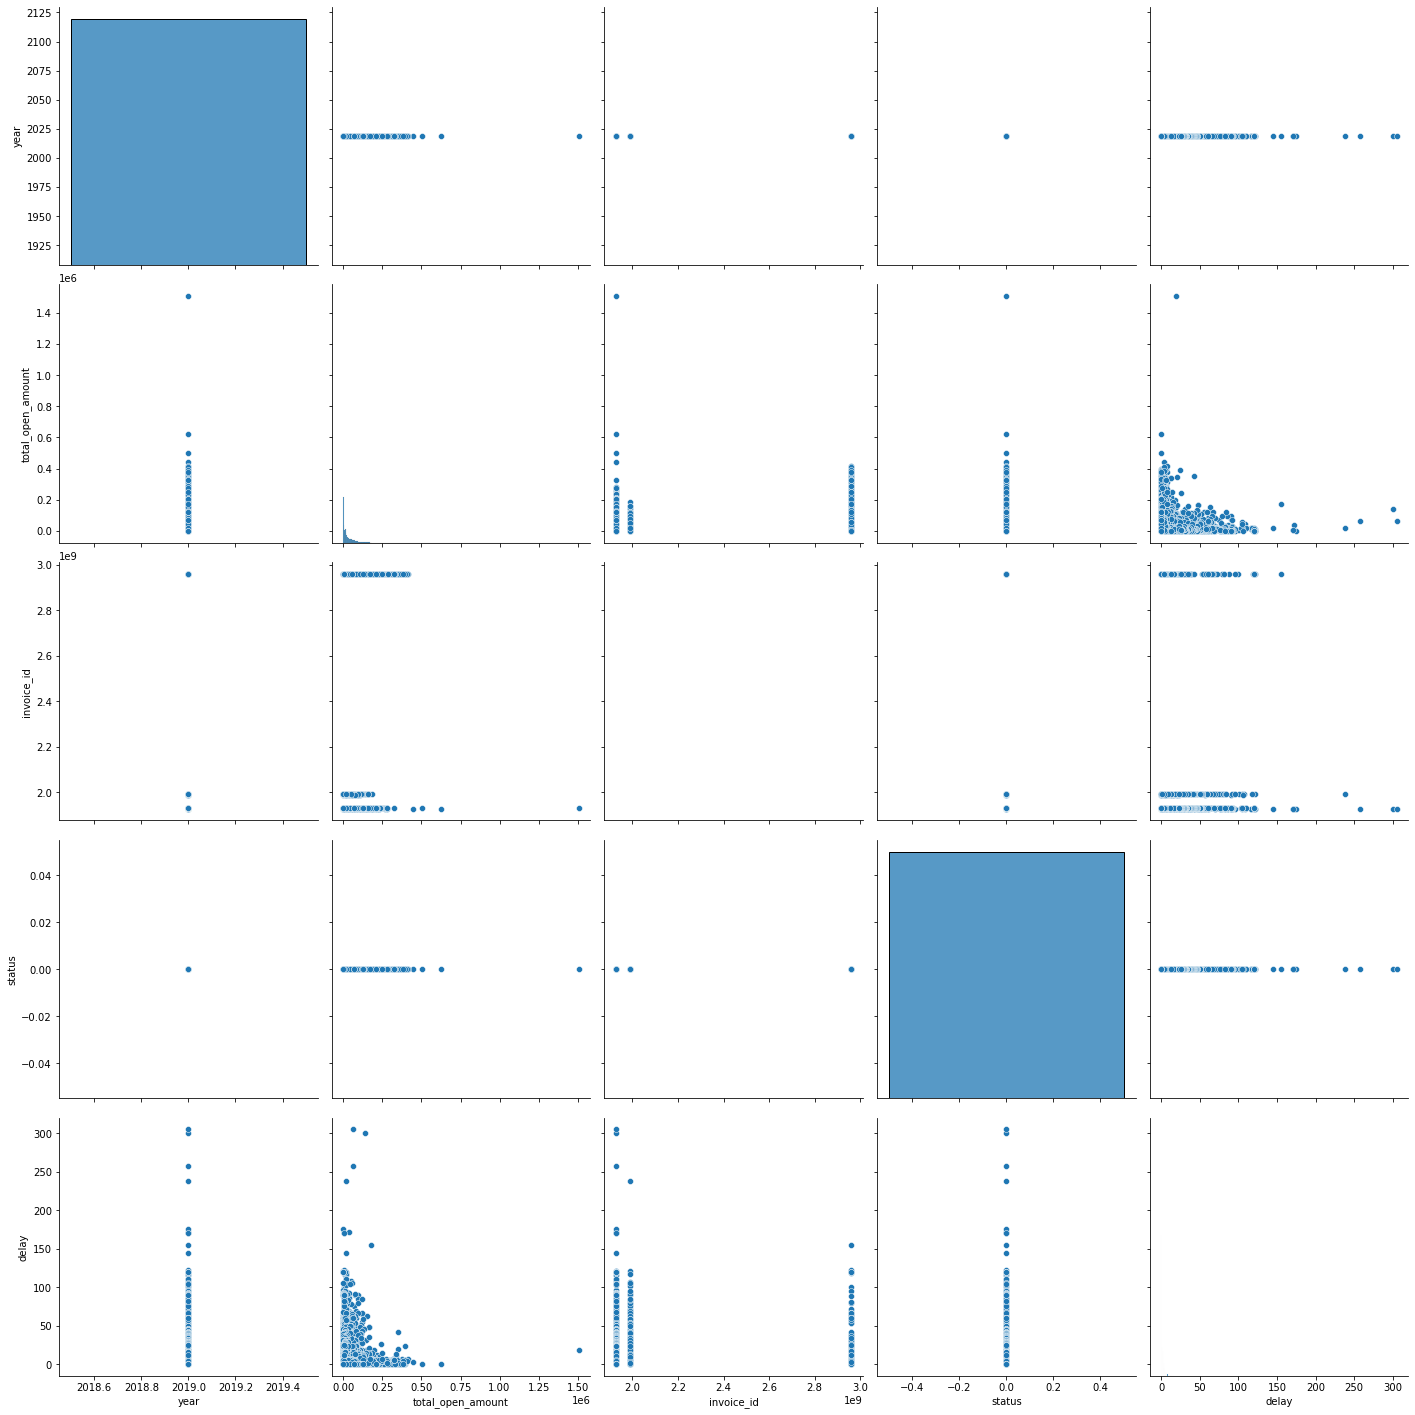

In [46]:
sns.pairplot(train_data, height=4)

# FEATURE ENGINEERING

In [47]:
train_data.drop(columns=['year', 'cust_payment_terms', 'status'], inplace=True)
train_data

,cust_number,invoice_create_date,due_in_date,clear_date,total_open_amount,invoice_id,delay
0,CCCA02,2018-12-30,2019-02-03,2019-03-01,13039.64,1.928537e+09,26.0
1,200769623,2018-12-30,2019-01-14,2019-01-10,33983.19,1.928542e+09,0.0
2,200769623,2018-12-30,2019-01-14,2019-01-16,41807.51,1.928541e+09,2.0
3,200255310,2018-12-30,2019-01-14,2019-01-14,1929.96,1.928543e+09,0.0
4,200769623,2018-12-30,2019-01-14,2019-01-10,26130.42,1.928543e+09,0.0
...,...,...,...,...,...,...,...
38481,200769623,2019-11-27,2019-12-12,2019-12-09,8877.58,1.930195e+09,0.0
38482,200726979,2019-11-27,2019-12-12,2019-12-12,27.60,1.930196e+09,0.0
38483,200769623,2019-11-27,2019-12-12,2019-12-09,17356.11,1.930195e+09,0.0
38484,140106408,2019-11-27,2019-12-07,2019-12-19,1478.78,2.960592e+09,12.0


In [48]:
train_data["invoice_create_day"] = train_data["invoice_create_date"].dt.day
train_data["invoice_create_month"] = train_data["invoice_create_date"].dt.month

train_data["due_day"] = train_data["due_in_date"].dt.day
train_data["due_month"] = train_data["due_in_date"].dt.month

In [49]:
train_data

,cust_number,invoice_create_date,due_in_date,clear_date,total_open_amount,invoice_id,delay,invoice_create_day,invoice_create_month,due_day,due_month
0,CCCA02,2018-12-30,2019-02-03,2019-03-01,13039.64,1.928537e+09,26.0,30,12,3,2
1,200769623,2018-12-30,2019-01-14,2019-01-10,33983.19,1.928542e+09,0.0,30,12,14,1
2,200769623,2018-12-30,2019-01-14,2019-01-16,41807.51,1.928541e+09,2.0,30,12,14,1
3,200255310,2018-12-30,2019-01-14,2019-01-14,1929.96,1.928543e+09,0.0,30,12,14,1
4,200769623,2018-12-30,2019-01-14,2019-01-10,26130.42,1.928543e+09,0.0,30,12,14,1
...,...,...,...,...,...,...,...,...,...,...,...
38481,200769623,2019-11-27,2019-12-12,2019-12-09,8877.58,1.930195e+09,0.0,27,11,12,12
38482,200726979,2019-11-27,2019-12-12,2019-12-12,27.60,1.930196e+09,0.0,27,11,12,12
38483,200769623,2019-11-27,2019-12-12,2019-12-09,17356.11,1.930195e+09,0.0,27,11,12,12
38484,140106408,2019-11-27,2019-12-07,2019-12-19,1478.78,2.960592e+09,12.0,27,11,7,12


# Extracting the integer part from cust_number

In [50]:
train_data['cn'] = train_data['cust_number'].str.extract('(\d+)')

# then will drop that column
train_data.drop('cust_number',axis=1,inplace=True)

#lets see the dataframe
train_data

,invoice_create_date,due_in_date,clear_date,total_open_amount,invoice_id,delay,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,2018-12-30,2019-02-03,2019-03-01,13039.64,1.928537e+09,26.0,30,12,3,2,02
1,2018-12-30,2019-01-14,2019-01-10,33983.19,1.928542e+09,0.0,30,12,14,1,200769623
2,2018-12-30,2019-01-14,2019-01-16,41807.51,1.928541e+09,2.0,30,12,14,1,200769623
3,2018-12-30,2019-01-14,2019-01-14,1929.96,1.928543e+09,0.0,30,12,14,1,200255310
4,2018-12-30,2019-01-14,2019-01-10,26130.42,1.928543e+09,0.0,30,12,14,1,200769623
...,...,...,...,...,...,...,...,...,...,...,...
38481,2019-11-27,2019-12-12,2019-12-09,8877.58,1.930195e+09,0.0,27,11,12,12,200769623
38482,2019-11-27,2019-12-12,2019-12-12,27.60,1.930196e+09,0.0,27,11,12,12,200726979
38483,2019-11-27,2019-12-12,2019-12-09,17356.11,1.930195e+09,0.0,27,11,12,12,200769623
38484,2019-11-27,2019-12-07,2019-12-19,1478.78,2.960592e+09,12.0,27,11,7,12,140106408


In [51]:
train_data.drop(columns=['clear_date', 'invoice_create_date', 'due_in_date'], inplace=True)
train_data

,total_open_amount,invoice_id,delay,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,13039.64,1.928537e+09,26.0,30,12,3,2,02
1,33983.19,1.928542e+09,0.0,30,12,14,1,200769623
2,41807.51,1.928541e+09,2.0,30,12,14,1,200769623
3,1929.96,1.928543e+09,0.0,30,12,14,1,200255310
4,26130.42,1.928543e+09,0.0,30,12,14,1,200769623
...,...,...,...,...,...,...,...,...
38481,8877.58,1.930195e+09,0.0,27,11,12,12,200769623
38482,27.60,1.930196e+09,0.0,27,11,12,12,200726979
38483,17356.11,1.930195e+09,0.0,27,11,12,12,200769623
38484,1478.78,2.960592e+09,12.0,27,11,7,12,140106408


In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38486 entries, 0 to 38485
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_open_amount     38486 non-null  float64
 1   invoice_id            38486 non-null  float64
 2   delay                 38486 non-null  float64
 3   invoice_create_day    38486 non-null  int64  
 4   invoice_create_month  38486 non-null  int64  
 5   due_day               38486 non-null  int64  
 6   due_month             38486 non-null  int64  
 7   cn                    38486 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 3.7+ MB


In [53]:
train_data['cn']=train_data['cn'].astype(str).astype(float)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38486 entries, 0 to 38485
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_open_amount     38486 non-null  float64
 1   invoice_id            38486 non-null  float64
 2   delay                 38486 non-null  float64
 3   invoice_create_day    38486 non-null  int64  
 4   invoice_create_month  38486 non-null  int64  
 5   due_day               38486 non-null  int64  
 6   due_month             38486 non-null  int64  
 7   cn                    38486 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


Splitting into x_train and y_train

In [54]:
y_train = train_data['delay']
y_train

0        26.0
1         0.0
2         2.0
3         0.0
4         0.0
         ... 
38481     0.0
38482     0.0
38483     0.0
38484    12.0
38485     0.0
Name: delay, Length: 38486, dtype: float64

In [55]:
x_train = train_data.drop(["delay"], axis=1).copy()
x_train

,total_open_amount,invoice_id,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,13039.64,1.928537e+09,30,12,3,2,2.0
1,33983.19,1.928542e+09,30,12,14,1,200769623.0
2,41807.51,1.928541e+09,30,12,14,1,200769623.0
3,1929.96,1.928543e+09,30,12,14,1,200255310.0
4,26130.42,1.928543e+09,30,12,14,1,200769623.0
...,...,...,...,...,...,...,...
38481,8877.58,1.930195e+09,27,11,12,12,200769623.0
38482,27.60,1.930196e+09,27,11,12,12,200726979.0
38483,17356.11,1.930195e+09,27,11,12,12,200769623.0
38484,1478.78,2.960592e+09,27,11,7,12,140106408.0


In [56]:
val1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3293 entries, 0 to 3292
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cust_number          3293 non-null   object        
 1   invoice_create_date  3293 non-null   datetime64[ns]
 2   due_in_date          3293 non-null   datetime64[ns]
 3   clear_date           3293 non-null   datetime64[ns]
 4   year                 3293 non-null   int64         
 5   total_open_amount    3293 non-null   float64       
 6   cust_payment_terms   3293 non-null   object        
 7   invoice_id           3293 non-null   float64       
 8   status               3293 non-null   int64         
 9   delay                3293 non-null   float64       
dtypes: datetime64[ns](3), float64(3), int64(2), object(2)
memory usage: 257.4+ KB


In [57]:
val1['delay']=val1.delay.apply(lambda x: 0 if x<0 else x)
val1.drop([ 'clear_date', 'year', 'cust_payment_terms', 'status'], axis=1, inplace=True)

val1["invoice_create_day"] = val1["invoice_create_date"].dt.day
val1["invoice_create_month"] = val1["invoice_create_date"].dt.month

val1["due_day"] = val1["due_in_date"].dt.day
val1["due_month"] = val1["due_in_date"].dt.month

val1['cn'] = val1['cust_number'].str.extract('(\d+)')
val1.drop('cust_number',axis=1,inplace=True)

val1.drop(columns=['invoice_create_date', 'due_in_date'], inplace=True)
val1

,total_open_amount,invoice_id,delay,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,39193.09,1.930198e+09,0.0,27,11,12,12,200780383
1,134145.60,1.930202e+09,0.0,28,11,13,12,200780383
2,29035.26,1.930201e+09,5.0,28,11,13,12,200739044
3,5547.11,2.960592e+09,0.0,28,11,13,12,140104409
4,95681.58,1.930199e+09,0.0,28,11,13,12,200920735
...,...,...,...,...,...,...,...,...
3288,69844.79,1.930385e+09,1.0,12,1,27,1,200769623
3289,1185.74,1.930388e+09,0.0,12,1,27,1,200769623
3290,84296.28,1.930381e+09,0.0,12,1,27,1,200752302
3291,19616.47,1.930389e+09,1.0,12,1,27,1,200744019


In [58]:
val1['cn']=val1['cn'].astype(str).astype(float)
val1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3293 entries, 0 to 3292
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_open_amount     3293 non-null   float64
 1   invoice_id            3293 non-null   float64
 2   delay                 3293 non-null   float64
 3   invoice_create_day    3293 non-null   int64  
 4   invoice_create_month  3293 non-null   int64  
 5   due_day               3293 non-null   int64  
 6   due_month             3293 non-null   int64  
 7   cn                    3293 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 205.9 KB


In [59]:
y_val1 = val1['delay']
y_val1

0       0.0
1       0.0
2       5.0
3       0.0
4       0.0
       ... 
3288    1.0
3289    0.0
3290    0.0
3291    1.0
3292    1.0
Name: delay, Length: 3293, dtype: float64

In [60]:
x_val1 = val1.drop(["delay"], axis=1).copy()
x_val1

,total_open_amount,invoice_id,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,39193.09,1.930198e+09,27,11,12,12,200780383.0
1,134145.60,1.930202e+09,28,11,13,12,200780383.0
2,29035.26,1.930201e+09,28,11,13,12,200739044.0
3,5547.11,2.960592e+09,28,11,13,12,140104409.0
4,95681.58,1.930199e+09,28,11,13,12,200920735.0
...,...,...,...,...,...,...,...
3288,69844.79,1.930385e+09,12,1,27,1,200769623.0
3289,1185.74,1.930388e+09,12,1,27,1,200769623.0
3290,84296.28,1.930381e+09,12,1,27,1,200752302.0
3291,19616.47,1.930389e+09,12,1,27,1,200744019.0


In [61]:
val2['delay']=val2.delay.apply(lambda x: 0 if x<0 else x)
val2.drop([ 'clear_date', 'year','cust_payment_terms', 'status'], axis=1, inplace=True)

val2["invoice_create_day"] = val2["invoice_create_date"].dt.day
val2["invoice_create_month"] = val2["invoice_create_date"].dt.month

val2["due_day"] = val2["due_in_date"].dt.day
val2["due_month"] = val2["due_in_date"].dt.month

val2['cn'] = val2['cust_number'].str.extract('(\d+)')
val2.drop('cust_number',axis=1,inplace=True)

val2.drop(columns=['invoice_create_date', 'due_in_date'], inplace=True)
val2

,total_open_amount,invoice_id,delay,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,132024.53,1.930386e+09,1.0,13,1,28,1,200735528
1,38835.64,1.930396e+09,1.0,13,1,28,1,200772670
2,96877.92,2.960606e+09,0.0,13,1,1,2,140104225
3,50582.31,1.930389e+09,0.0,13,1,28,1,200769623
4,14233.12,1.930392e+09,0.0,13,1,28,1,200729942
...,...,...,...,...,...,...,...,...
4763,33765.66,1.930571e+09,3.0,27,2,13,3,200763152
4764,39408.22,1.930574e+09,3.0,27,2,13,3,200744707
4765,12610.49,1.930577e+09,0.0,27,2,13,3,200794332
4766,90195.02,1.930580e+09,2.0,27,2,18,3,200700919


In [62]:
val2['cn']=val2['cn'].astype(str).astype(float)
val2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768 entries, 0 to 4767
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_open_amount     4768 non-null   float64
 1   invoice_id            4768 non-null   float64
 2   delay                 4768 non-null   float64
 3   invoice_create_day    4768 non-null   int64  
 4   invoice_create_month  4768 non-null   int64  
 5   due_day               4768 non-null   int64  
 6   due_month             4768 non-null   int64  
 7   cn                    4768 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 298.1 KB


In [63]:
y_val2 = val2['delay']
y_val2

0       1.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
4763    3.0
4764    3.0
4765    0.0
4766    2.0
4767    0.0
Name: delay, Length: 4768, dtype: float64

In [64]:
x_val2 = val2.drop(["delay"], axis=1).copy()
x_val2

,total_open_amount,invoice_id,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,132024.53,1.930386e+09,13,1,28,1,200735528.0
1,38835.64,1.930396e+09,13,1,28,1,200772670.0
2,96877.92,2.960606e+09,13,1,1,2,140104225.0
3,50582.31,1.930389e+09,13,1,28,1,200769623.0
4,14233.12,1.930392e+09,13,1,28,1,200729942.0
...,...,...,...,...,...,...,...
4763,33765.66,1.930571e+09,27,2,13,3,200763152.0
4764,39408.22,1.930574e+09,27,2,13,3,200744707.0
4765,12610.49,1.930577e+09,27,2,13,3,200794332.0
4766,90195.02,1.930580e+09,27,2,18,3,200700919.0


In [65]:
x_test.drop([ 'clear_date', 'year', 'cust_payment_terms', 'status'], axis=1, inplace=True)

x_test["invoice_create_day"] = x_test["invoice_create_date"].dt.day
x_test["invoice_create_month"] = x_test["invoice_create_date"].dt.month

x_test["due_day"] = x_test["due_in_date"].dt.day
x_test["due_month"] = x_test["due_in_date"].dt.month

x_test['cn'] = x_test['cust_number'].str.extract('(\d+)')
x_test.drop('cust_number',axis=1,inplace=True)

x_test.drop(columns=['invoice_create_date', 'due_in_date'], inplace=True)
x_test

,total_open_amount,invoice_id,invoice_create_day,invoice_create_month,due_day,due_month,cn
0,50394.62,1.930577e+09,27,2,13,3,200780383
1,10240.80,2.960618e+09,27,2,8,3,140106181
2,9955.20,1.930577e+09,27,2,27,2,013
3,23155.48,1.930567e+09,27,2,13,3,200742521
4,95862.39,1.930575e+09,27,2,13,3,200472086
...,...,...,...,...,...,...,...
3442,1247.36,1.930887e+09,12,5,27,5,200769623
3443,106094.04,1.930885e+09,13,5,28,5,200762950
3444,17812.00,1.930876e+09,14,5,29,5,200915438
3445,7800.00,1.930880e+09,14,5,29,5,200915438


In [66]:
x_test['cn']=x_test['cn'].astype(str).astype(float)
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_open_amount     3447 non-null   float64
 1   invoice_id            3447 non-null   float64
 2   invoice_create_day    3447 non-null   int64  
 3   invoice_create_month  3447 non-null   int64  
 4   due_day               3447 non-null   int64  
 5   due_month             3447 non-null   int64  
 6   cn                    3447 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 188.6 KB


# FEATURE SELECTION

<AxesSubplot:>

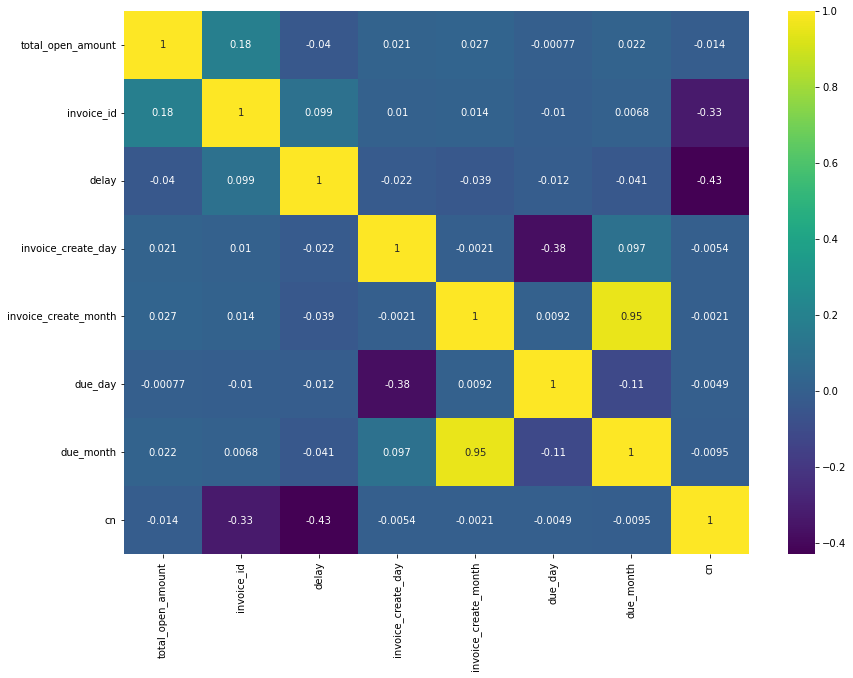

In [67]:
plt.figure(figsize=(14,10))
cor = train_data.corr()
sns.heatmap(cor,cmap = 'viridis',annot=True)

In [68]:
x_train = x_train.drop(["due_month"], axis=1).copy()
x_val1 = x_val1.drop(["due_month"], axis=1).copy()
x_val2 = x_val2.drop(["due_month"], axis=1).copy()
x_test = x_test.drop(["due_month"], axis=1).copy()

# MODELING

XGBoost

In [69]:
#fitting the model 

clf = xgb.XGBRegressor()
clf.fit(x_train, y_train)

# Predicting the Validation Set Results
predicted = clf.predict(x_val1)

In [70]:
# predicting all types of error and accuracy

print("Mean absolute error =", round(sm.mean_absolute_error(y_val1, predicted), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_val1, predicted), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_val1, predicted), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_val1, predicted), 2)) 
print("R2 score =", round(sm.r2_score(y_val1, predicted), 2))
print("Accuracy= ", clf.score(x_val1,y_val1))

Mean absolute error = 3.1
Mean squared error = 46.55
Median absolute error = 2.4
Explain variance score = 0.15
R2 score = 0.14
Accuracy=  0.14265444016032802


# Random Forest

In [71]:
clf2 = RandomForestRegressor()
clf2.fit(x_train, y_train)

# Predicting the Validation Set Results
predicted2 = clf2.predict(x_val1)

In [72]:
# predicting all types of error and accuracy

print("Mean absolute error =", round(sm.mean_absolute_error(y_val1, predicted2), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_val1, predicted2), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_val1, predicted2), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_val1, predicted2), 2)) 
print("R2 score =", round(sm.r2_score(y_val1, predicted2), 2))
print("Accuracy= ", clf2.score(x_val1,y_val1))

Mean absolute error = 2.71
Mean squared error = 40.27
Median absolute error = 1.63
Explain variance score = 0.29
R2 score = 0.26
Accuracy=  0.2583090840469918


# DecisionTreeRegressor

In [73]:
# Fitting Decision Tree Regressor to the Training Set
clf3 = DecisionTreeRegressor()
clf3.fit(x_train, y_train)

# Predicting the Validation Set Results
predicted3 = clf3.predict(x_val1)

In [74]:
# predicting all types of error and accuracy

print("Mean absolute error =", round(sm.mean_absolute_error(y_val1, predicted3), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_val1, predicted3), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_val1, predicted3), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_val1, predicted3), 2)) 
print("R2 score =", round(sm.r2_score(y_val1, predicted3), 2))
print("Accuracy= ", clf3.score(x_val1,y_val1))

Mean absolute error = 3.86
Mean squared error = 91.99
Median absolute error = 2.0
Explain variance score = -0.63
R2 score = -0.69
Accuracy=  -0.6940267257636319


# LinearRegression

In [75]:
# Fitting Simple Linear Regression to the Training Set
clf5 = LinearRegression()
clf5.fit(x_train, y_train)

# Predicting the Test Set Results
predicted5 = clf.predict(x_val1)

In [76]:
# predicting all types of error and accuracy

print("Mean absolute error =", round(sm.mean_absolute_error(y_val1, predicted5), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_val1, predicted5), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_val1, predicted5), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_val1, predicted5), 2)) 
print("R2 score =", round(sm.r2_score(y_val1, predicted5), 2))
print("Accuracy= ", clf5.score(x_val1,y_val1))

Mean absolute error = 3.1
Mean squared error = 46.55
Median absolute error = 2.4
Explain variance score = 0.15
R2 score = 0.14
Accuracy=  0.2120466786579267


# HYPER-PARAMETER TUNING

In [77]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}


In [78]:
reg=xgb.XGBRegressor()
random_search=RandomizedSearchCV(reg,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [79]:
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   verbose=3)

In [80]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [81]:
cl = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=3, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
cl.fit(x_train, y_train)
# Predicting the Test Set Results
predicted = cl.predict(x_val2)

In [82]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_val2, predicted), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_val2, predicted), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_val2, predicted), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_val2, predicted), 2)) 
print("R2 score =", round(sm.r2_score(y_val2, predicted), 2))
print("Accuracy= ", cl.score(x_val2,y_val2))

Mean absolute error = 2.45
Mean squared error = 30.94
Median absolute error = 1.22
Explain variance score = 0.41
R2 score = 0.41
Accuracy=  0.4073118280057152


# hyper parameter tuning for random forest

In [92]:
params={
    'bootstrap': [True],

    'max_depth': [80, 90, 100, 110],

    'max_features': [2, 3],

    'min_samples_leaf': [3, 4, 5],

    'min_samples_split': [8, 10, 12],

    'n_estimators': [100, 200, 300, 1000]}

In [93]:
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = params, 

                          cv = 3, n_jobs = -1, verbose = 2)

In [94]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [95]:
best_grid = grid_search.best_estimator_

In [96]:
best_grid

RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=5,
                      min_samples_split=12, n_estimators=200)

In [97]:
cl = RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=5,
                      min_samples_split=12, n_estimators=200)
cl.fit(x_train, y_train)
# Predicting the Test Set Results
predicted = cl.predict(x_val2)

In [98]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_val2, predicted), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_val2, predicted), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_val2, predicted), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_val2, predicted), 2)) 
print("R2 score =", round(sm.r2_score(y_val2, predicted), 2))
print("Accuracy= ", cl.score(x_val2,y_val2))

Mean absolute error = 3.46
Mean squared error = 30.8
Median absolute error = 2.88
Explain variance score = 0.49
R2 score = 0.41
Accuracy=  0.40995583168081196


# TEST

In [153]:
predicted1 = cl.predict(x_test)

In [154]:
predicted1=np.around(predicted1)
predicted1.astype(int)

array([ 4, 44, 30, ...,  5,  3,  4])

In [155]:
len(predicted1)

3447

In [156]:
Col=pd.DataFrame()

In [157]:
Delay=[]
for x in predicted1:
    Delay.append(pd.Timedelta(days=x))
Col['Delay'] = Delay
Col

,Delay
0,4 days
1,44 days
2,30 days
3,3 days
4,3 days
...,...
3442,3 days
3443,2 days
3444,5 days
3445,3 days


In [158]:
Col['clear_date'] = ts['due_in_date']+Col['Delay']
Col

,Delay,clear_date
0,4 days,2020-03-17
1,44 days,2020-04-21
2,30 days,2020-03-28
3,3 days,2020-03-16
4,3 days,2020-03-16
...,...,...
3442,3 days,2020-05-30
3443,2 days,2020-05-30
3444,5 days,2020-06-03
3445,3 days,2020-06-01


In [159]:
Col['custid']=x_test['cn']

In [160]:
Col.head()

,Delay,clear_date,custid
0,4 days,2020-03-17,200780383.0
1,44 days,2020-04-21,140106181.0
2,30 days,2020-03-28,13.0
3,3 days,2020-03-16,200742521.0
4,3 days,2020-03-16,200472086.0


In [161]:
predicteddays = []
for x in predicted1:
    if x<=15:
        predicteddays.append("0-15days")
    elif x<=30:
        predicteddays.append("16-30days")
    elif x<=45:
        predicteddays.append("31-45days")
    elif x<=60:
        predicteddays.append("46-60days")
    else:
        predicteddays.append("Greater than 60 days")
Col['predicteddays']= predicteddays
Col.drop(['Delay'],axis=1,inplace=True)
Col.loc[:3000]

,clear_date,custid,predicteddays
0,2020-03-17,200780383.0,0-15days
1,2020-04-21,140106181.0,31-45days
2,2020-03-28,13.0,16-30days
3,2020-03-16,200742521.0,0-15days
4,2020-03-16,200472086.0,0-15days
...,...,...,...
2996,2020-05-16,200794332.0,0-15days
2997,2020-05-15,200769623.0,0-15days
2998,2020-05-16,140104472.0,0-15days
2999,2020-05-15,200769623.0,0-15days


In [162]:
x_test.head(3000)

,total_open_amount,invoice_id,invoice_create_day,invoice_create_month,due_day,cn
0,50394.62,1.930577e+09,27,2,13,200780383.0
1,10240.80,2.960618e+09,27,2,8,140106181.0
2,9955.20,1.930577e+09,27,2,27,13.0
3,23155.48,1.930567e+09,27,2,13,200742521.0
4,95862.39,1.930575e+09,27,2,13,200472086.0
...,...,...,...,...,...,...
2995,30220.01,1.930831e+09,28,4,13,200794332.0
2996,43234.89,1.930834e+09,28,4,13,200794332.0
2997,62583.26,1.930832e+09,28,4,13,200769623.0
2998,10479.60,2.960631e+09,28,4,11,140104472.0
